# Statistical Operations, Resampling and Climatologies Using Xarray

In this notebook:

* Setup and Load Data 
* Common Operations 
* Resampling and Rolling Mean
* Groupby and Climatology
* Plot - Extras

This example uses Coupled Model Intercomparison Project (CMIP6) collections. For more information, please visit [data catalogue]( https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/metadata/f6600_2266_8675_3563) and [terms of use]( https://pcmdi.llnl.gov/CMIP6/TermsOfUse/TermsOfUse6-1.html).

---------

- Authors: NCI Virtual Research Environment Team
- Keywords: CMIP6, xarray, resample, rolling mean, groupby, climatology, cartopy
- Create Date: 2019-Dec; Update Date: 2020-Apr
- Lineage/Reference: This example was modified from the original example developed by Dr Aidan Heerdegen from ARC COE Clex.

### Prerequisite

To run this notebook on Gadi/VDI, or on your local computer. The following modules are needed:

* Xarray
* netCDF4
* matplotlib
* Cartopy

You also need to be a member of the following data project to access the data or through [NCI's data service](http://dapds00.nci.org.au/thredds/catalog.html) if the data is published:
* oi10

You can request to join the project through [NCI's user account management system](https://my.nci.org.au). 

### Setup and Load Data

#### Load the required modules

In [1]:
import xarray as xr
import netCDF4 as nc
%matplotlib inline

#### Opening Multiple Files at Once

xarray's `open_mfdataset` allows multiple files to be opened simultaneously and concatenated as one file.

In [ ]:
!ls /g/data/oi10/replicas/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701
path = '/g/data/oi10/replicas/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/*'
f_hist = xr.open_mfdataset(path)
tas = f_hist.tas - 273.15

### Common Operations

Xarray supports many of the statistical operations commonly performed on climate data arrays. Examples include:

    Mean
    Standard Deviation
    Minimum
    Maximum

The operations are done with numpy-like syntax that many users are familiar with: `.mean()`, `.stddef()`, etc. For example, calculating a simple mean would be done via:


In [6]:
tas.mean()

<xarray.DataArray 'tas' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0

The above mean( ) happened very quickly because of lazy loading, which we talked about before. The resultant array still remains an xarray DataArray.

### Xarray Operations and Missing Values

In general when using numpy, a user would need to mask out the missing or nan values of an array. As long as the nan or missing values are defined in the data array, the operations in general will be performed excluding those values.

In [7]:
import numpy as np
nan_test=xr.DataArray([1,3,np.nan])
nan_test.mean()

<xarray.DataArray ()>
array(2.)

### Xarray Operations on Subsets

As with data subsetting, one of the advantages of xarray is that it permits operations to be performed via a specified list of dimension labels.

For example, to calculate the mean in time would be:

In [8]:
tas.mean(dim = 'time')

<xarray.DataArray 'tas' (lat: 180, lon: 288)>
dask.array<mean_agg-aggregate, shape=(180, 288), dtype=float32, chunksize=(180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

To calculate the mean over lat and lon you will need to take into account the size of the grid cells and weight the mean by the area of those grid cells.

In CMIP6 the cell areas are included under the CMIP_table parameter 'fx' for atmosphere and land parameters and 'Ofx' for ocean. In this case we will use area of atmospheric cells areacella.

In [9]:
file_area = xr.open_dataset('/g/data/oi10/replicas/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/\
r1i1p1f1/fx/areacella/gr1/v20180701/areacella_fx_GFDL-CM4_historical_r1i1p1f1_gr1.nc')
area = file_area.areacella
area

<xarray.DataArray 'areacella' (lat: 180, lon: 288)>
array([[1.348703e+08, 1.348703e+08, 1.348703e+08, ..., 1.348703e+08,
        1.348703e+08, 1.348703e+08],
       [4.045698e+08, 4.045698e+08, 4.045698e+08, ..., 4.045698e+08,
        4.045698e+08, 4.045698e+08],
       [6.741460e+08, 6.741460e+08, 6.741460e+08, ..., 6.741460e+08,
        6.741460e+08, 6.741460e+08],
       ...,
       [6.741460e+08, 6.741460e+08, 6.741460e+08, ..., 6.741460e+08,
        6.741460e+08, 6.741460e+08],
       [4.045698e+08, 4.045698e+08, 4.045698e+08, ..., 4.045698e+08,
        4.045698e+08, 4.045698e+08],
       [1.348703e+08, 1.348703e+08, 1.348703e+08, ..., 1.348703e+08,
        1.348703e+08, 1.348703e+08]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Attributes:
    long_name:      Grid-Cell Area for Atmospheric Variables
    units:          m2
    standard_name:  cell_area
    cell_methods:   area: sum
    interp_method:  conserve_order1
    original_name:  areacella

We can now calculate the area weighted mean using the above variable and xarray operations.

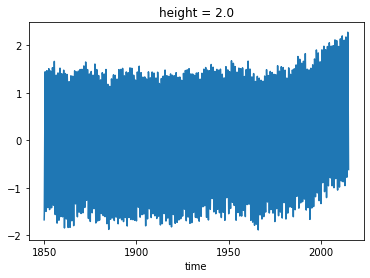

In [10]:
tas_area = tas*area
tas_wmean = tas_area.sum(['lat','lon']) / (area.sum())
tas_anom = tas_wmean - tas_wmean.mean()
tas_anom.plot()

### Exercise

Find the minimum temperature in a box spanning the coordinates

    lon: 80 - 120
    lat: 10N - 20N

<a href="#ans1" data-toggle="collapse">Answer</a>
<div class="collapse" id="ans1">
<pre><code>
tas.sel(lat=slice(10,20),lon=slice(80,120)).min()
</code></pre>
</div>

### Resampling and Rolling Mean

The previous time-series plot was a bit hectic. We probably want to resample in time or take a rolling mean to remove the smaller scales of the data and see the longer term trend.

xarray very easily supports both resampling and rolling means with the `.rolling` and the `.resample` operations. 

Starting with a rolling mean we'll use a 1 year window (time=12 as is monthly data).

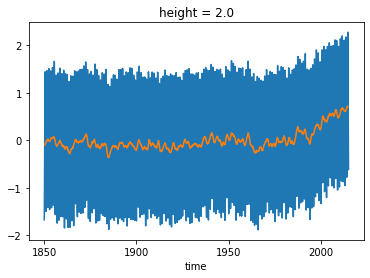

In [11]:
tas_roll = tas_anom.rolling(time=12,center=True).mean()
tas_anom.plot()
tas_roll.plot()

Resampling can work in a similar way to the rolling mean. Resampling works with time data (with datetime64 variable in dimensions) and allows you to change the time frequency of your data. If you have a monthly dataset and you want that as a yearly dataset (or a 6hrly dataset that you want daily, etc) you can use the resample command while taking the mean over the resampling period.

In the example below we have defined the new resampling period to be annual 'A' and have taken the mean over the monthly data in each year to produce a yearly average time series. Compare it to the rolling mean case above.

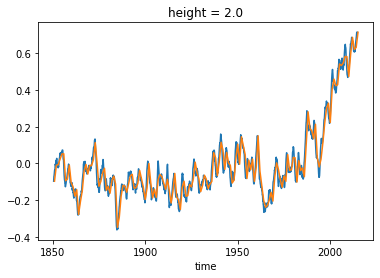

In [12]:
tas_res=tas_anom.resample(time='A').mean(dim='time')
tas_roll.plot()
tas_res.plot()

### Exercise

Try rolling or resampling at other frequencies. Look at smaller subsets to see the difference.

### Climatology

With `.groupby()` you can easily create a climatology and calculate anomalies. In this example, working with monthly data, a new dimension will be created that is the months of the year. 

Let's create a climatology from pre-1900 data:

In [13]:
climatology = tas.sel(time=slice('1800','1900')).groupby('time.month').mean(dim='time')
climatology

<xarray.DataArray 'tas' (month: 12, lat: 180, lon: 288)>
dask.array<stack, shape=(12, 180, 288), dtype=float32, chunksize=(1, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Instead of grouping by month, group by 'season'. Plot one of the seasons.

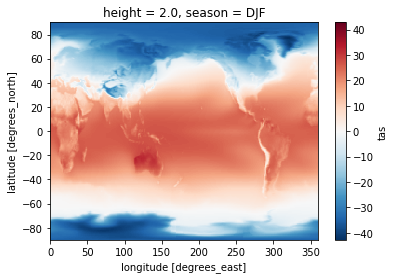

In [14]:
climatology_seas = tas.sel(time=slice('1800','1900')).groupby('time.season').mean(dim='time')
climatology_seas.sel(season='DJF').plot()

### Plot - Extras

### Subplots

In the seasonal climatology case we have created a climatology with 4 periods in time relating to seasons. It is very simple to plot all the seasons in a single plot simply by specifying which variable defines the `row` and how many columns to produce (we have also defined the colourbar limits using `vmin` and `vmax`):

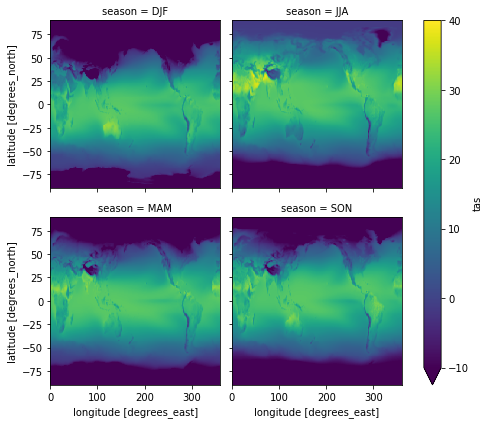

In [15]:
climatology_seas.plot(row='season',col_wrap=2,vmin=-10,vmax=40)

We can integrate projections with the xarray datasets using the cartopy command.

Notes: you need to install or load Cartopy to be able to run this part of the exercise.

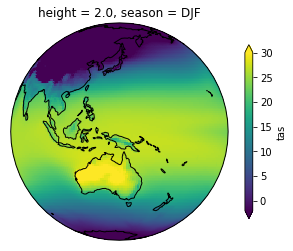

In [15]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=140))
ax.coastlines()

climatology_seas.sel(season='DJF').plot(transform=ccrs.PlateCarree(), vmin=-2, vmax=30,
            cbar_kwargs={'shrink': 0.8})

### Exercise

Make your own plot using your favorite projection: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html

### Summary

This example shows some common operations in xarray.

## Reference

http://xarray.pydata.org/en/stable/